In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
from tqdm import tqdm
from random import shuffle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Reading the Images

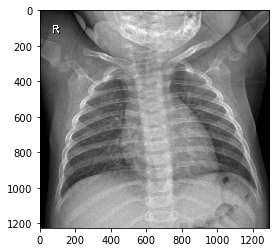

In [2]:
img = cv2.imread("./data/train/NORMAL/IM-0319-0001.jpeg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Image Pre-Processing

In [3]:
img_size = 80

In [4]:
def image_preprocesser(path, label):
    temp_list = []
    for i in tqdm(os.listdir(path)):
        try:
            img = cv2.imread('{}/{}'.format(path,i))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            img = cv2.resize(img, (img_size,img_size))
            label = np.array(label)
            temp_list.append((img,label))
        except:
            print('Error Image Format')
    return temp_list

In [5]:
list_train_normal = image_preprocesser('./data/train/NORMAL/',0)
list_train_infect = image_preprocesser('./data/train/PNEUMONIA/',1)
list_val_normal = image_preprocesser('./data/val/NORMAL/',0)
list_val_infect = image_preprocesser('./data/val/PNEUMONIA/',1)
list_test_normal = image_preprocesser('./data/test/NORMAL/',0)
list_test_infect = image_preprocesser('./data/test/PNEUMONIA/',1)

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:07<00:00, 55.71it/s]


# Model Data Preparation

In [6]:
total_list = list_train_normal+list_train_infect+list_val_normal+list_val_infect+list_test_normal+list_test_infect

import random

random.shuffle(total_list)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = [i[0] for i in tqdm(total_list)]
X = np.array(X)
X = np.reshape(X, (-1,img_size,img_size,1))

y = [i[1] for i in tqdm(total_list)]
y = np.array(y)

100%|█████████████████████████████████████████████████████████████████████████| 5856/5856 [00:00<00:00, 2863353.26it/s]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

# Model Preparation

In [10]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau 

In [11]:
model_checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=True,
                                            monitor='val_acc', mode='max', save_best_only=True,verbose=1, )

model_earlystopping_callback = EarlyStopping(monitor='val_loss', patience=4)

model_plateau_callback = ReduceLROnPlateau(monitor='val_loss', patience=4)

callback_list = [model_checkpoint_callback, model_earlystopping_callback, model_plateau_callback]

In [12]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape = (img_size,img_size,1)))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.load_weights('best_model.h5')

In [14]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_split=0.15, callbacks=callback_list)

Train on 4230 samples, validate on 747 samples
Epoch 1/15
4230/4230 [==============================] - 248s 59ms/step - loss: 0.5732 - acc: 0.8532 - val_loss: 2.0671 - val_acc: 0.7497

Epoch 00001: val_acc improved from -inf to 0.74967, saving model to best_model.h5
Epoch 2/15
4230/4230 [==============================] - 246s 58ms/step - loss: 0.3060 - acc: 0.9319 - val_loss: 2.9910 - val_acc: 0.7497

Epoch 00002: val_acc did not improve from 0.74967
Epoch 3/15
4230/4230 [==============================] - 245s 58ms/step - loss: 0.2168 - acc: 0.9433 - val_loss: 0.7233 - val_acc: 0.7938

Epoch 00003: val_acc improved from 0.74967 to 0.79384, saving model to best_model.h5
Epoch 4/15
4230/4230 [==============================] - 250s 59ms/step - loss: 0.1643 - acc: 0.9480 - val_loss: 0.2450 - val_acc: 0.8969

Epoch 00004: val_acc improved from 0.79384 to 0.89692, saving model to best_model.h5
Epoch 5/15
4230/4230 [==============================] - 248s 59ms/step - loss: 0.1363 - acc: 0.9582

# Model's Results Exploration

In [15]:
df_model = pd.DataFrame(model.history.history)

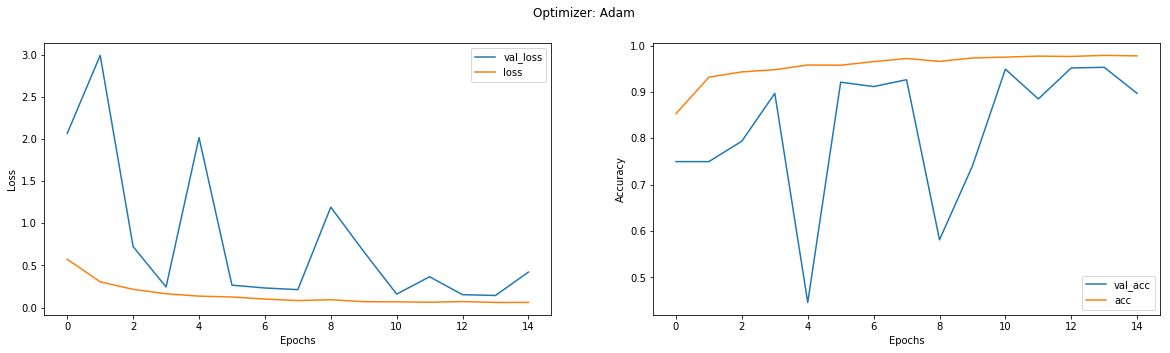

In [16]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.suptitle('Optimizer: Adam')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(df_model['val_loss'])
plt.plot(df_model['loss'])
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(df_model['val_acc'])
plt.plot(df_model['acc'])
plt.legend(loc=4)

In [14]:
predictions = model.predict_classes(X_test)

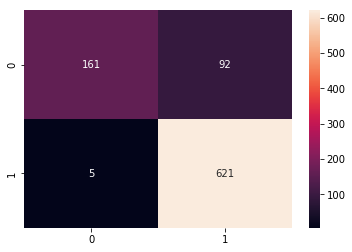

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True, fmt='g')

In [19]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.97      0.64      0.77       253
          1       0.87      0.99      0.93       626

avg / total       0.90      0.89      0.88       879



In [22]:
predictions[4]

0

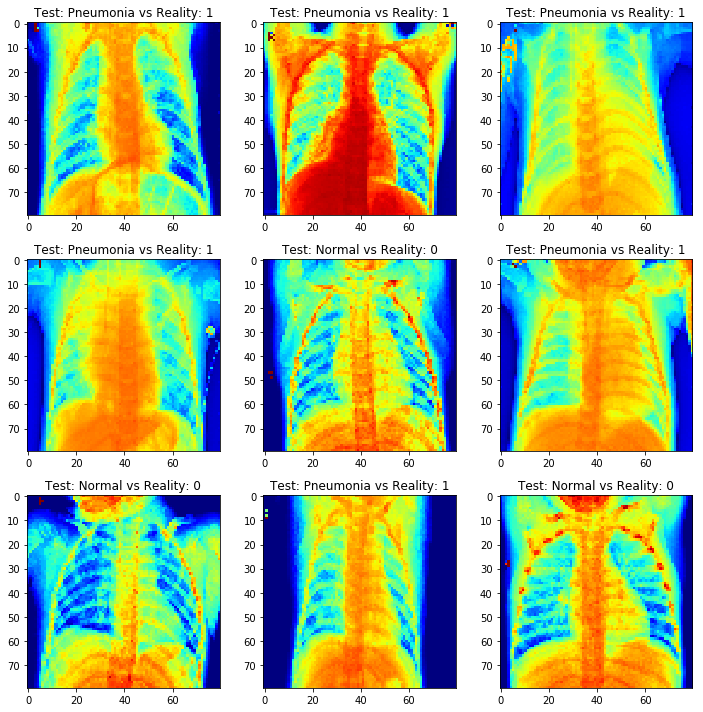

In [25]:
width=8
height=8
rows = 3
cols = 3
axes=[]
fig=plt.figure(figsize=(10,10))

for a in range(rows*cols):
    b = np.reshape(X_test[a], (img_size,img_size))
    axes.append(fig.add_subplot(rows, cols, a+1))
    if predictions[a] == 1:
        subplot_title=('Test: Pneumonia vs Reality: {}'.format(y_test[a]))
    else:
        subplot_title=('Test: Normal vs Reality: {}'.format(y_test[a]))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b, cmap='jet')
fig.tight_layout()    
plt.show()

# 1: Pneumonia, 0: Normal